# Notebook 02: Feature Selection with Recursive Feature Elimination

This notebook focuses on reducing model complexity and enhancing interpretability by applying recursive feature elimination (RFE) to identify the most impactful features. Our goal is to maintain predictive accuracy while using a smaller subset of features.

# Imports:

In [5]:
# Standard library imports
import math
import random
from datetime import date
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from scipy import stats

# Machine learning libraries
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import (MinMaxScaler, RobustScaler, FunctionTransformer, 
                                   OneHotEncoder, TargetEncoder, StandardScaler)
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# MLforecast related imports
from mlforecast import MLForecast

from mlforecast.target_transforms import Differences, GlobalSklearnTransformer
from mlforecast.feature_engineering import transform_exog

# Other forecasting utilities
from window_ops.rolling import rolling_mean, rolling_std

# Performance optimization
from numba import njit
from functools import partial

# Suppress warnings
warnings.filterwarnings('ignore')

# Local imports
from ml_forecast_evaluator import MLForecast_Evaluator

# Data loading:

In [16]:
data = pd.read_pickle('./data/transformed_full_features_data_157f.pkl')
data['y'] = np.expm1(data['y']) #Transformed df includes a log transform of target

train_index = sorted(list(data["ds"].unique()))[:-2]
valid_index = [sorted(list(data["ds"].unique()))[-2]]
test_index = [sorted(list(data["ds"].unique()))[-1]]

train = data.loc[data['ds'].isin(train_index)]
valid = data.loc[data['ds'].isin(valid_index)]
test = data.loc[data['ds'].isin(test_index)]

# Recursive feature selection

## Models

In [3]:
tunned_xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.04090017424394747,
    max_depth=4,
    subsample=0.6178983774980504,
    colsample_bytree=0.16820470246691538,
    min_child_weight=14, 
    verbose=False,
    random_state=23)

tunned_cb = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.09750549984022183,
    depth=4,
    subsample=0.8351887897835678,
    colsample_bylevel=0.6200486399899717,
    min_data_in_leaf=93,
    silent=True,
    random_state=23)

tunned_models = [tunned_xgb, tunned_cb]

## Without validation set

In [10]:
full_train = pd.concat([train, valid])
full_train = full_train.set_index(['ds', 'unique_id']).dropna()

X = full_train.drop('y', axis=1)
y = full_train['y']

### XGBoost

In [16]:
# Perform Recursive Feature Elimination
n_features_to_select = 30
rfe = RFE(estimator=tunned_xgb, n_features_to_select=n_features_to_select)
rfe = rfe.fit(X, y)

# Get selected features
selected_features_xgb = X.columns[rfe.support_].tolist()

print("Selected features:")
print(selected_features_xgb)

Selected features:
['monthly_average_price', 'year', 'quarter', 'around_Xmas', 'month_sin', 'month_cos', 'item_id_y_sum_lag1', 'item_id_y_max_lag1', 'item_id_y_max_lag2', 'item_id_city_id_y_sum_lag1', 'item_id_city_id_y_max_lag1', 'item_id_city_id_y_min_lag1', 'item_id_city_id_y_min_lag2', 'shop_id_item_category_id_y_max_lag1', 'shop_id_item_category_id_y_min_lag1', 'item_category_id_year_monthly_average_price_max', 'item_category_id_year_monthly_average_price_min', 'item_id_quarter_monthly_average_price_mean', 'item_category_id_quarter_revenue_mean', 'item_category_id_quarter_revenue_std', 'item_id_month_revenue_mean', 'item_category_id_month_revenue_mean', 'city_id_month_revenue_mean', 'ytd_sales', 'quarterly_sales', 'price_change', 'lag1', 'lag2', 'rolling_mean_lag1_window_size2', 'rolling_mean_lag2_window_size2']


### Catboost

In [18]:
# Perform Recursive Feature Elimination
n_features_to_select = 30
rfe = RFE(estimator=tunned_cb, n_features_to_select=n_features_to_select)
rfe = rfe.fit(X, y)

# Get selected features
selected_features_cb = X.columns[rfe.support_].tolist()

print("Selected features:")
print(selected_features_cb)

Selected features:
['monthly_average_price', 'year', 'quarter', 'around_Xmas', 'month_sin', 'month_cos', 'item_id_y_sum_lag2', 'item_id_y_max_lag1', 'item_category_id_y_max_lag1', 'item_id_city_id_y_max_lag1', 'item_category_id_revenue_max_lag2', 'item_id_city_id_revenue_min_lag1', 'item_category_id_city_id_revenue_sum_lag2', 'city_id_revenue_sum_lag1', 'city_id_revenue_sum_lag2', 'shop_id_year_monthly_average_price_std', 'item_category_id_year_monthly_average_price_mean', 'item_category_id_year_revenue_mean', 'item_id_quarter_revenue_max', 'item_id_around_Xmas_revenue_mean', 'item_id_month_revenue_mean', 'item_category_id_month_revenue_mean', 'city_id_month_revenue_mean', 'ytd_sales', 'quarterly_sales', 'price_change', 'lag1', 'lag2', 'rolling_mean_lag1_window_size2', 'rolling_mean_lag2_window_size2']


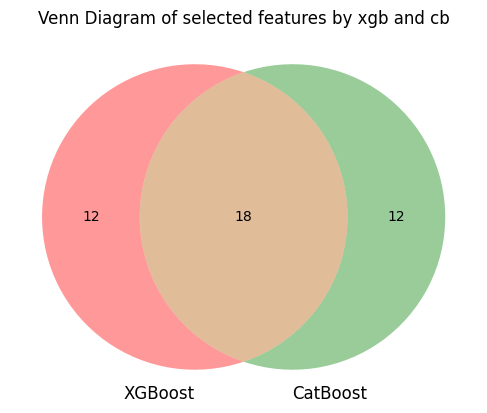

In [6]:
## Intersect selected features

selected_features_xgb = ['monthly_average_price', 'year', 'quarter', 'around_Xmas', 'month_sin', 'month_cos', 'item_id_y_sum_lag1', 'item_id_y_max_lag1', 'item_id_y_max_lag2', 'item_id_city_id_y_sum_lag1', 'item_id_city_id_y_max_lag1', 'item_id_city_id_y_min_lag1', 'item_id_city_id_y_min_lag2', 'shop_id_item_category_id_y_max_lag1', 'shop_id_item_category_id_y_min_lag1', 'item_category_id_year_monthly_average_price_max', 'item_category_id_year_monthly_average_price_min', 'item_id_quarter_monthly_average_price_mean', 'item_category_id_quarter_revenue_mean', 'item_category_id_quarter_revenue_std', 'item_id_month_revenue_mean', 'item_category_id_month_revenue_mean', 'city_id_month_revenue_mean', 'ytd_sales', 'quarterly_sales', 'price_change', 'lag1', 'lag2', 'rolling_mean_lag1_window_size2', 'rolling_mean_lag2_window_size2']
selected_features_cb = ['monthly_average_price', 'year', 'quarter', 'around_Xmas', 'month_sin', 'month_cos', 'item_id_y_sum_lag2', 'item_id_y_max_lag1', 'item_category_id_y_max_lag1', 'item_id_city_id_y_max_lag1', 'item_category_id_revenue_max_lag2', 'item_id_city_id_revenue_min_lag1', 'item_category_id_city_id_revenue_sum_lag2', 'city_id_revenue_sum_lag1', 'city_id_revenue_sum_lag2', 'shop_id_year_monthly_average_price_std', 'item_category_id_year_monthly_average_price_mean', 'item_category_id_year_revenue_mean', 'item_id_quarter_revenue_max', 'item_id_around_Xmas_revenue_mean', 'item_id_month_revenue_mean', 'item_category_id_month_revenue_mean', 'city_id_month_revenue_mean', 'ytd_sales', 'quarterly_sales', 'price_change', 'lag1', 'lag2', 'rolling_mean_lag1_window_size2', 'rolling_mean_lag2_window_size2']

set1 = set(selected_features_xgb)
set2 = set(selected_features_cb)

# Create the Venn Diagram
venn2(subsets = [set1, set2], set_labels = ('XGBoost', 'CatBoost'))
plt.title("Venn Diagram of selected features by xgb and cb")
plt.show()

# Test with XGBoost selected features

## Train, val, test selected

In [17]:
train_valid_columns = [col for col in selected_features_xgb if col in train.columns] + ['y', 'ds', 'unique_id']
train_selected = train[train_valid_columns]
valid_selected = valid[train_valid_columns]
test_selected = test[train_valid_columns]

In [18]:
future_df = pd.concat([train_selected, valid_selected]).drop('y', axis=1)

In [19]:
print(train_selected.shape)
print(valid_selected.shape)

print(future_df.shape)

(12354, 33)
(426, 33)
(12780, 32)


In [23]:
@njit
def diff(x, lag):
    x2 = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2

sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

fcst = MLForecast(
    models=tunned_models,
    freq='M',
    target_transforms=[GlobalSklearnTransformer(sk_log1p)],
    num_threads=6
)

In [24]:
fcst.fit(train_selected, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=[])

MLForecast(models=[XGBRegressor, CatBoostRegressor], freq=M, lag_features=[], date_features=[], num_threads=6)

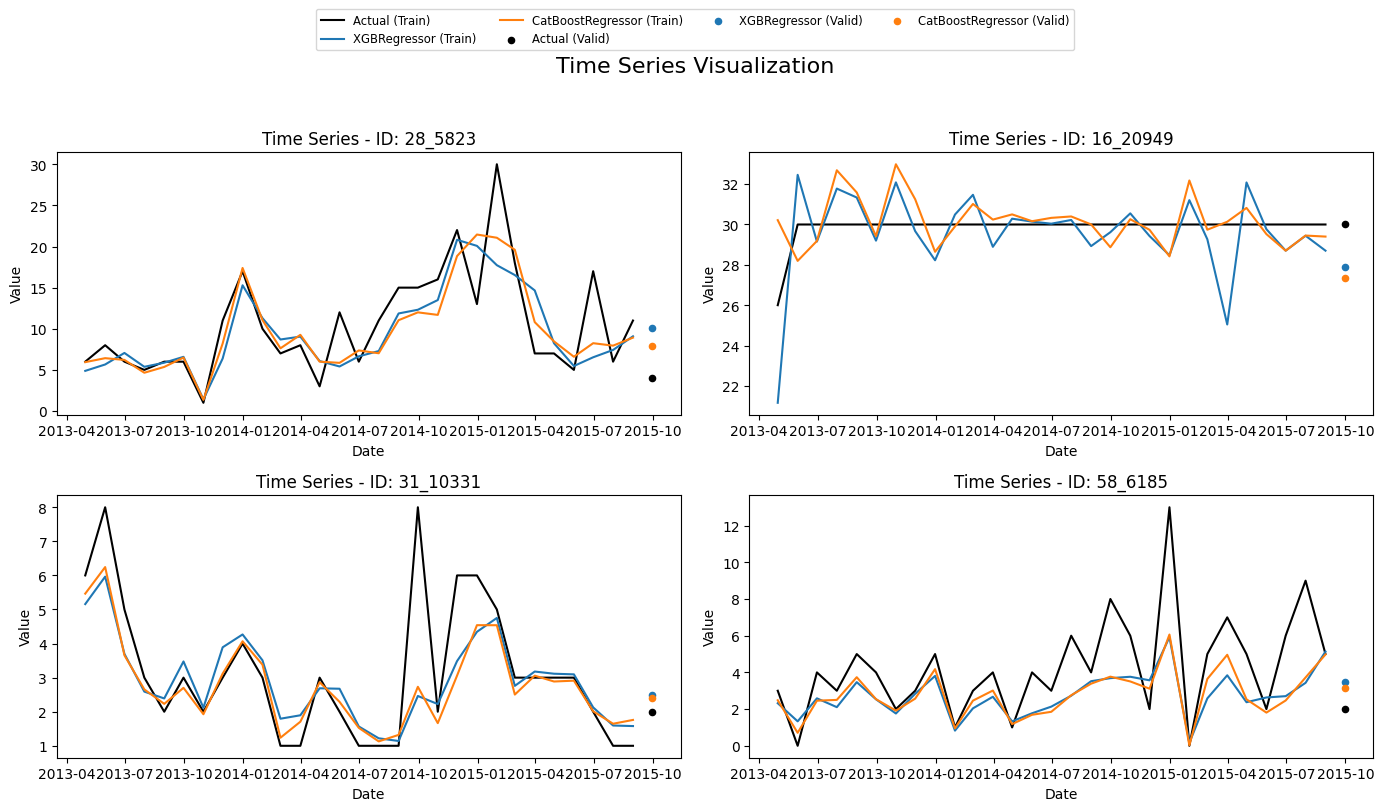

MEAN RMSE_VALID = 2.6921405228785433

Model with lowest RMSE validation is XGBRegressor with RMSE = 2.6299722548205273

                   RMSE_train  R2_train  RMSE_valid  R2_valid
XGBRegressor         2.476912  0.903808    2.629972  0.872934
CatBoostRegressor    2.071920  0.932693    2.754309  0.860636


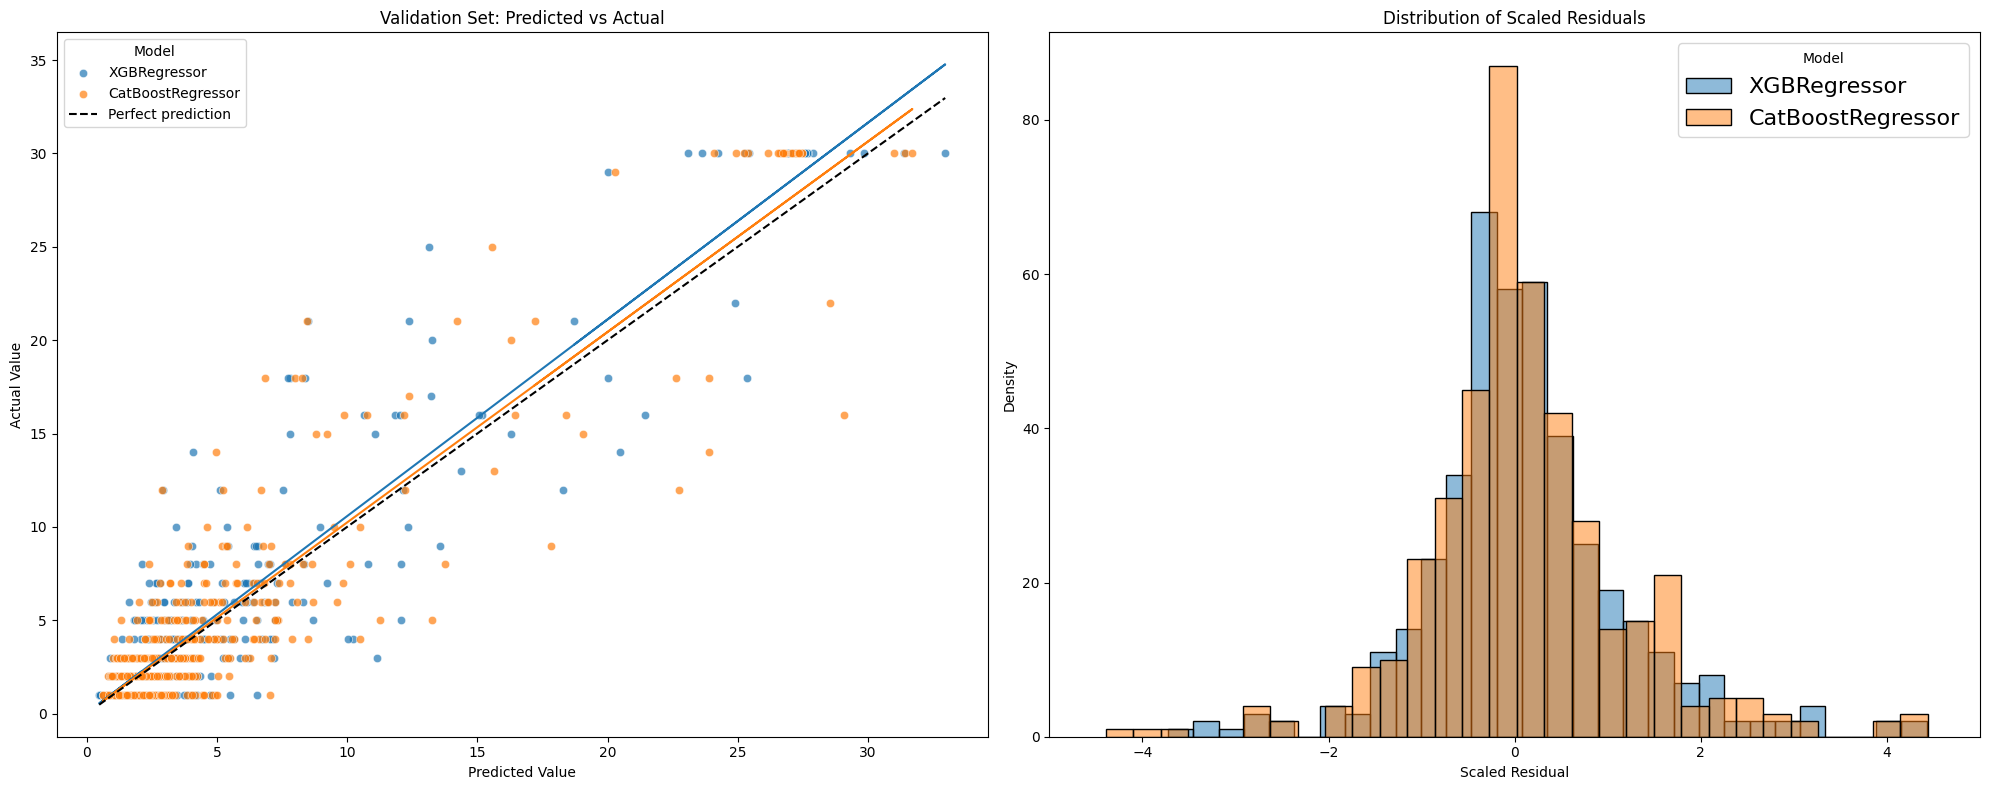

In [26]:
evaluator = MLForecast_Evaluator(fcst, valid_selected, future_df, h=1)

evaluator.plot_time_series(n_samples=4)  # Will show 4 random time series in a 2x2 grid

# Calculate and print metrics
evaluator.calculate_metrics()

# Plot metrics
evaluator.plot_metrics()

# Predicting future values (test) with train+valid fit

In [27]:
full_train = pd.concat([train_selected, valid_selected])
future_df2 = test_selected.drop('y', axis=1)

In [28]:
fcst.fit(full_train, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=[])

MLForecast(models=[XGBRegressor, CatBoostRegressor], freq=M, lag_features=[], date_features=[], num_threads=6)

In [29]:
# Predict h=2 and save second prediction as submission
evaluator_test = MLForecast_Evaluator(fcst, valid, future_df2, h=1)
#evaluator.calculate_metrics()

#for model in evaluator.model_columns:
model = 'XGBRegressor'
evaluator_test.predict_save_submission(model, test_index=test_index)

Submission file 'submissions/2024-07-19_submission_XGBRegressor_mean_valid_RMSE_unknown.csv' has been created successfully.


,unique_id,monthly_sales
0,12_11365,14.523080
1,12_11369,24.622837
2,12_11370,29.132795
3,12_11373,28.804327
4,12_12231,2.333480
...,...,...
421,7_5822,5.739323
422,7_6185,2.163548
423,7_6497,3.301038
424,7_7856,2.622172
